## Jupyter notebook 02: Analysis of Collaborative Toponyms in OpenStreetMap

***Paper: Collaborative Toponyms in OpenStreetMap: an open-source framework to investigate the relationship with intrinsic quality parameters***

**Aims**

- To conduct a quantitative assessment of elements within OpenStreetMap (OSM) that have the 'name' attribute filled for potential categories of the Brazilian Authoritative Topographic Map; and

- To investigate the most significant intrinsic quality parameters that contribute to the reliability of toponyms in OSM.


**Brief Overview of the Proposed Methodology**

- Preliminary survey of potential OpenStreetMap (OSM) tags to provide relevant toponym information to categories of interest related to Brazilian Topographic Mapping;

- Execution of a quantitative analysis on collaboratively entered toponyms, utilizing homogeneous grid-based approaches; and

- Assessment of intrinsic quality parameters as indicators of the reliability of toponyms in a scientific context.

---

### Install the necessary libraries to the analysis

In [ ]:
# Just in case of using colab, install these necessary libraries
%pip install geopandas matplotlib pysal seaborn mapclassify mgwr -q

### Import the libraries

In [156]:
# Import library and some pre-installed modules
import os
import sys
import numpy as np
import json
import folium
import pandas as pd
import geopandas as gpd
import mapclassify
import matplotlib.colors
import seaborn as sns
import statsmodels.api as sm
import warnings
import pyproj
import time
from matplotlib import pyplot as plt
from ipywidgets import widgets, Layout, Button, interact, Dropdown, SelectMultiple, HBox, VBox
from IPython.display import display, clear_output
from folium import plugins, Map, Choropleth, Element, Figure, GeoJson
from folium.features import GeoJson, GeoJsonTooltip
from pysal.explore import esda
from pysal.lib import weights
from shapely.geometry import MultiPolygon, box
from shapely.ops import transform
from jinja2 import Template
from tqdm.notebook import tqdm
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from esda import G_Local
from esda.moran import Moran
from splot.esda import plot_moran


%matplotlib inline

In [2]:
# Sets the root directory of the project as the working directory
os.chdir('..')


In [3]:
# Check the current working directory
os.getcwd()

'/Users/darlanmnunes/Dev/DSc_git/PhD_Thesis_Step1_OSM_Toponyms'

In [5]:
# Check the current directories in the working directory
%ls

LICENSE     data/       notebooks/  utils/
README.md   deprecated/ results/


### Connect to Google Drive (*just in case of using Google Colaboratory environment*)

In [ ]:
# Cell to run just in case of using colab, conect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

### Analysis of Collaborative Toponyms in OpenStreetMap

#### Import the regular grid cells with the aggregated data extracted from OSM via the OHSOME API (JN1)

In [139]:
# Import the grid with the aggregated data extracted from OSM via the OHSOME API
grid_osm = None

# Output to display messages
output = widgets.Output()

# Base path for the directories with GeoJSON files
base_path = 'data/output_code1'

# Store the name of the selected GeoJSON file
selected_file = None

# Function for selecting and loading the GeoJSON file
def select_file(change):
    global grid_osm, selected_file
    selected_file = change['new']
    
    if selected_file != "Select the GeoJSON file of the case study area:":
        file_path = os.path.join(base_path, selected_file)
        try:
            with open(file_path, 'r') as file:
                grid_osm = json.load(file)
            with output:
                clear_output(wait=True)
                print("File selected: %s loaded with success!" %(selected_file))
                print("\nFile path:", file_path)
        except FileNotFoundError:
            with output:
                clear_output(wait=True)
                print("File not found:", selected_file)

# Listing available GeoJSON files
file_list = [f for f in os.listdir(base_path) if f.endswith('.geojson')]
options = ["Select the GeoJSON file of the case study area:"] + file_list

# Dropdown to select the GeoJSON file
dropdown = widgets.Dropdown(options=options)
dropdown.observe(select_file, names='value')

# Display the dropdown
display(dropdown, output)

Dropdown(options=('Select the GeoJSON file of the case study area:', 'grade_id77_passare_results.geojson', 'gr…

Output()

In [140]:
# Preview grid cells in GeoJSON format
display(grid_osm)

{'type': 'FeatureCollection',
 'crs': {'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:EPSG::4674'}},
 'features': [{'type': 'Feature',
   'properties': {'id': '200ME54798N84962',
    'POP10': 834,
    'leisure_total_count': 0.0,
    'leisure_name_count': 0.0,
    'leisure_name_ratio': 0,
    'building_total_count': 1.0,
    'building_name_count': 1.0,
    'building_name_ratio': 100.0,
    'amenity_total_count': 1.0,
    'amenity_name_count': 1.0,
    'amenity_name_ratio': 100.0,
    'leisure_total_contributions': 0.0,
    'leisure_name_contributions': 0.0,
    'building_total_contributions': 7.0,
    'building_name_contributions': 5.0,
    'amenity_total_contributions': 4.0,
    'amenity_name_contributions': 4.0,
    'leisure_latest5_name_contributions': 0.0,
    'building_latest5_name_contributions': 2.0,
    'amenity_latest5_name_contributions': 1.0,
    'leisure_name_tagChange_contributions': 0.0,
    'building_name_tagChange_contributions': 2.0,
    'amenity_name_tagChange

#### Convert GeoJSON Data to GeoDataFrame

In [141]:
# Convert GeoJSON Data to GeoDataFrame
gdf_osm = gpd.GeoDataFrame.from_features(grid_osm['features'])

In [142]:
# Check the five first and last records of GeoDataFrame
display(gdf_osm)

,geometry,id,POP10,leisure_total_count,leisure_name_count,leisure_name_ratio,building_total_count,building_name_count,building_name_ratio,amenity_total_count,...,amenity_name_contributions,leisure_latest5_name_contributions,building_latest5_name_contributions,amenity_latest5_name_contributions,leisure_name_tagChange_contributions,building_name_tagChange_contributions,amenity_name_tagChange_contributions,leisure_users_count_name,building_users_count_name,amenity_users_count_name
0,"MULTIPOLYGON (((-49.29112 -25.46861, -49.29116...",200ME54798N84962,834,0.0,0.0,0.000000,1.0,1.0,100.000000,1.0,...,4.0,0.0,2.0,1.0,0.0,2.0,2.0,0.0,3.0,3.0
1,"MULTIPOLYGON (((-49.29312 -25.46681, -49.29315...",200ME54796N84964,475,3.0,2.0,66.666667,5.0,1.0,20.000000,2.0,...,4.0,1.0,1.0,2.0,1.0,0.0,0.0,3.0,3.0,4.0
2,"MULTIPOLYGON (((-49.29116 -25.46678, -49.29119...",200ME54798N84964,368,2.0,1.0,50.000000,1.0,0.0,0.000000,4.0,...,5.0,1.0,1.0,4.0,1.0,0.0,0.0,2.0,1.0,4.0
3,"MULTIPOLYGON (((-49.29315 -25.46498, -49.29318...",200ME54796N84966,218,1.0,0.0,0.000000,2.0,2.0,100.000000,3.0,...,7.0,0.0,1.0,3.0,0.0,0.0,2.0,0.0,3.0,6.0
4,"MULTIPOLYGON (((-49.29119 -25.46495, -49.29122...",200ME54798N84966,1086,0.0,0.0,0.000000,2.0,1.0,50.000000,13.0,...,39.0,0.0,1.0,15.0,0.0,0.0,10.0,0.0,2.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,"MULTIPOLYGON (((-49.27981 -25.44282, -49.27984...",200ME54810N84990,683,0.0,0.0,0.000000,37.0,4.0,10.810811,4.0,...,13.0,0.0,4.0,4.0,0.0,11.0,2.0,0.0,15.0,8.0
150,"MULTIPOLYGON (((-49.27785 -25.44279, -49.27788...",200ME54812N84990,973,3.0,2.0,66.666667,28.0,3.0,10.714286,6.0,...,16.0,1.0,2.0,0.0,7.0,7.0,3.0,10.0,11.0,11.0
151,"MULTIPOLYGON (((-49.27589 -25.44276, -49.27592...",200ME54814N84990,1389,1.0,1.0,100.000000,23.0,3.0,13.043478,2.0,...,4.0,1.0,3.0,2.0,7.0,0.0,0.0,9.0,3.0,3.0
152,"MULTIPOLYGON (((-49.26970 -25.45912, -49.26973...",200ME54820N84972,269,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [143]:
# Check the number os grid cell with information retrived of OSM
len(gdf_osm)

154

In [144]:
gdf_osm.crs

---
#### Quantitative Analysis

##### 1. Histogram Analysis

Dropdown(description='Column:', index=5, options=('geometry', 'id', 'POP10', 'leisure_total_count', 'leisure_n…

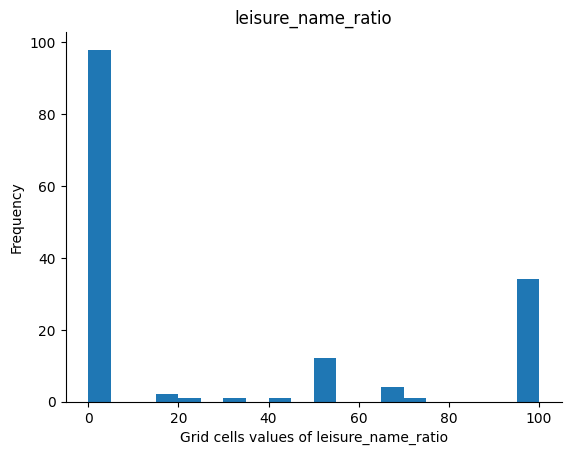

In [11]:
# Preliminary analysis with histograms

# Creating a selection widget for columns
dropdown = widgets.Dropdown(
    options = gdf_osm.columns, # list of DataFrame columns
    value = 'leisure_name_ratio', # default value
    description = 'Column:',
    disabled = False,
)

# Function to plot the histogram
def plot_histogram(column):
    clear_output(wait=True) # clears the previous output
    display(dropdown)  # Show the widget again after clearing the output

    # Plots the histogram for the specified column
    gdf_osm[column].plot(kind='hist', bins=20, title=column)

    # Styling the graphic
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.xlabel(f'Grid cells values of {column}')  # add the  X axis title
    plt.show()

# Linking the plot function to the dropdown value change event
dropdown.observe(lambda change: plot_histogram(change.new), 'value')

# Show the widget
display(dropdown)

# Initial plot
plot_histogram(dropdown.value)

##### 2. Ordinary Least Squares (OLS) regression

In [12]:
# Convert GeoDataFrame to DataFrame by removing the geometry column
gdf_osm_copy = gdf_osm.copy()
df_osm = gdf_osm_copy.drop(columns=['geometry'])

In [13]:
# Check the five first and last records of DataFrame
display(df_osm)

,id,POP10,leisure_total_count,leisure_name_count,leisure_name_ratio,building_total_count,building_name_count,building_name_ratio,amenity_total_count,amenity_name_count,...,amenity_name_contributions,leisure_latest5_name_contributions,building_latest5_name_contributions,amenity_latest5_name_contributions,leisure_name_tagChange_contributions,building_name_tagChange_contributions,amenity_name_tagChange_contributions,leisure_users_count_name,building_users_count_name,amenity_users_count_name
0,200ME54798N84962,834,0.0,0.0,0.000000,1.0,1.0,100.000000,1.0,1.0,...,4.0,0.0,2.0,1.0,0.0,2.0,2.0,0.0,3.0,3.0
1,200ME54796N84964,475,3.0,2.0,66.666667,5.0,1.0,20.000000,2.0,2.0,...,4.0,1.0,1.0,2.0,1.0,0.0,0.0,3.0,3.0,4.0
2,200ME54798N84964,368,2.0,1.0,50.000000,1.0,0.0,0.000000,4.0,3.0,...,5.0,1.0,1.0,4.0,1.0,0.0,0.0,2.0,1.0,4.0
3,200ME54796N84966,218,1.0,0.0,0.000000,2.0,2.0,100.000000,3.0,3.0,...,7.0,0.0,1.0,3.0,0.0,0.0,2.0,0.0,3.0,6.0
4,200ME54798N84966,1086,0.0,0.0,0.000000,2.0,1.0,50.000000,13.0,13.0,...,39.0,0.0,1.0,15.0,0.0,0.0,10.0,0.0,2.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,200ME54810N84990,683,0.0,0.0,0.000000,37.0,4.0,10.810811,4.0,4.0,...,13.0,0.0,4.0,4.0,0.0,11.0,2.0,0.0,15.0,8.0
150,200ME54812N84990,973,3.0,2.0,66.666667,28.0,3.0,10.714286,6.0,3.0,...,16.0,1.0,2.0,0.0,7.0,7.0,3.0,10.0,11.0,11.0
151,200ME54814N84990,1389,1.0,1.0,100.000000,23.0,3.0,13.043478,2.0,1.0,...,4.0,1.0,3.0,2.0,7.0,0.0,0.0,9.0,3.0,3.0
152,200ME54820N84972,269,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# Check the data types
df_osm.dtypes

id                                        object
POP10                                      int64
leisure_total_count                      float64
leisure_name_count                       float64
leisure_name_ratio                       float64
building_total_count                     float64
building_name_count                      float64
building_name_ratio                      float64
amenity_total_count                      float64
amenity_name_count                       float64
amenity_name_ratio                       float64
leisure_total_contributions              float64
leisure_name_contributions               float64
building_total_contributions             float64
building_name_contributions              float64
amenity_total_contributions              float64
amenity_name_contributions               float64
leisure_latest5_name_contributions       float64
building_latest5_name_contributions      float64
amenity_latest5_name_contributions       float64
leisure_name_tagChan

In [15]:
# Perform Multiple Linear Regression (OLS)
# Dynamic selection of the dependent variable and the independent variables
# Dependent variables
dependent_var_widget = Dropdown(options=[col for col in df_osm.columns if col != 'id'],
                                description='Dependent Var:',value = 'leisure_name_ratio')

# Independent variables
independent_vars_widget = SelectMultiple(
    options=[col for col in df_osm.columns if col != 'id'],
    description='Independent Vars (use ctrl to select multiple variables):',
    layout={'width': '90%', 'height': '200px'})

# Global Dictionary to store all regression summaries
regression_summaries = {}

# Global dictionary for storing R² values
r2_values = {}

# Function to run the regression
def run_regression(button):
    global regression_summaries, r2_values
    dependent_var = dependent_var_widget.value
    independent_vars = list(independent_vars_widget.value)
    X = df_osm[independent_vars]
    y = df_osm[dependent_var]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    regression_summary = model.summary().as_text()

    # Print the summary for the current run
    print(regression_summary)

    # Store the summary using the model name as the key
    model_name = f"{dependent_var} ~ {' + '.join(independent_vars)}"
    regression_summaries[model_name] = regression_summary

    # Store R² Adjusted values
    r2_values[model_name] = model.rsquared_adj

# Function to clear the outputs
def clear_outputs(button):
    clear_output()
    display_widgets()

# Function to save all regression results
def save_regression_results(button):
    save_path = 'results/2_OLS_regression/regression_summaries.txt'
    if regression_summaries:
        with open(save_path, "w") as file:
            for model, summary in regression_summaries.items():
                file.write(f"Model: {model}\n")
                file.write(f"{summary}\n\n")
        print("All results saved successfully.")
    else:
        print("No results to save.")

# Function to Generate the Bar Chart for Adjusted R² Values
def plot_r2_bar_chart():
    # Convert the dictionary of R² values into a DataFrame for visualization
    df_r2 = pd.DataFrame(list(r2_values.items()), columns=['Model', 'Adjusted R2'])

    # Sort the models by 'Adjusted R2' values for better visualization
    df_r2_sorted = df_r2.sort_values(by='Adjusted R2', ascending=True)

    # Create the bar chart with bars closer together
    fig, ax = plt.subplots(figsize=(10, 8))
    bars = sns.barplot(x='Adjusted R2', y='Model', data=df_r2_sorted, palette='viridis', dodge=False)

    # Add labels and title for the chart
    ax.set_xlabel('Adjusted R²')
    ax.set_ylabel('Model')
    ax.set_title('Adjusted R² Values for Different Regression Models')

    # Add the values on the bars
    for bar in bars.patches:
        ax.text(
            bar.get_width(),  # get the horizontal end point of the bar
            bar.get_y() + bar.get_height() / 2,  # get the y position of the bar
            f'{bar.get_width():.2f}',  # the value we want to add as text
            va='center',  # vertical alignment
            ha='left',  # horizontal alignment
            color='black',  # text color
            fontweight='light'  # font weight
        )

    # Display the chart
    plt.tight_layout()
    plt.show()

# Function to Buttons actions
def button_actions(b):
    if b.description == 'Run Regression':
        run_regression(b)
    elif b.description == 'Clear Outputs':
        clear_outputs(b)
    elif b.description == 'Save Results':
        save_regression_results(b)
    elif b.description == 'Generate R² bar chart':
        plot_r2_bar_chart()

# Create Buttons to run the analysis
run_button = Button(description='Run Regression')
heatmap_button = Button(description='Generate R² bar chart')
save_button = Button(description="Save Results")
clear_button = Button(description="Clear Outputs")

# Assign the button_actions function as the on_click event handler for all buttons
for button in [run_button, heatmap_button, save_button, clear_button]:
    button.on_click(button_actions)

# Organize the widgets
variable_selection_box = VBox([dependent_var_widget, independent_vars_widget])
buttons_box = VBox([run_button, heatmap_button, save_button, clear_button])

# Function to display the widgets
def display_widgets():
    hbox = HBox([variable_selection_box, buttons_box])
    display(hbox)

# Display the Widgets and the Buttons
display_widgets()

---
#### Spatial Patterns Analysis

##### 3. Choropleth maps

In [145]:
# Choropleth maps with Manual Styling Option

# Ensure that that gdf_osm and selected_file are already loaded

# Set CRS if needed
if gdf_osm.crs is None:
    gdf_osm = gdf_osm.set_crs("EPSG:4674")

# Output directory for choropleth maps
output_path = 'results/3_choropleth_maps/'

# Ignore future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Calculate the centroid of the union of all geometries
def calculate_centroid_of_union(gdf):
    union_poly = gdf.geometry.unary_union
    if isinstance(union_poly, MultiPolygon):
        union_poly = MultiPolygon(union_poly).convex_hull
    return [union_poly.centroid.y, union_poly.centroid.x]

# Generate choropleth map (manual style or folium built-in)
def add_choropleth(map_obj, column, method, palette, manual_style=False):
    unique_values = len(gdf_osm[column].unique())
    k = min(4, unique_values)

    if method == 'Quantiles':
        classifier = mapclassify.Quantiles(gdf_osm[column], k=k)
        class_labels = classifier.yb
        bins = [gdf_osm[column].min()] + list(classifier.bins)
        labels = [f"Q{i+1}" for i in range(len(bins)-1)]

    elif method == 'EqualInterval':
        classifier = mapclassify.EqualInterval(gdf_osm[column], k=k)
        class_labels = classifier.yb
        bins = [gdf_osm[column].min()] + list(classifier.bins)
        labels = ['' for _ in range(len(bins)-1)]

    elif method == 'NaturalBreaks':
        classifier = mapclassify.NaturalBreaks(gdf_osm[column], k=k)
        class_labels = classifier.yb
        bins = [gdf_osm[column].min()] + list(classifier.bins)
        labels = ['' for _ in range(len(bins)-1)]

    elif method == 'EqualIntervalCustom':
        bins = [0, 25, 50, 75, 100]
        class_labels = pd.cut(
            gdf_osm[column],
            bins=bins,
            labels=False,
            include_lowest=True,
            right=True
        )
        labels = ['' for _ in range(len(bins)-1)]

    else:
        raise ValueError("Classification method not supported")

    gdf_osm['class'] = class_labels

    cmap = matplotlib.colormaps.get_cmap(palette)
    colors = [matplotlib.colors.to_hex(cmap(i / max(1, len(bins)-2))) for i in range(len(bins)-1)]

    if manual_style:
        # Manual styling with GeoJson
        def style_function(feature):
            class_value = feature['properties']['class']
            if class_value is None or np.isnan(class_value):
                return {'fillOpacity': 0, 'weight': 0}
            else:
                return {
                    'fillColor': colors[int(class_value)],
                    'color': 'black',
                    'weight': 0.4,
                    'fillOpacity': 0.6
                }

        folium.GeoJson(
            data=gdf_osm.to_json(),
            style_function=style_function,
            tooltip=folium.GeoJsonTooltip(fields=['id', column])
        ).add_to(map_obj)

    else:
        # Default folium choropleth
        choropleth = folium.Choropleth(
            geo_data=gdf_osm.to_json(),
            data=gdf_osm,
            columns=['id', 'class'],
            key_on='feature.properties.id',
            fill_color=palette,
            fill_opacity=0.5,
            line_opacity=0.4,
            legend_name=''
        ).add_to(map_obj)

        folium.GeoJsonTooltip(fields=['id', column]).add_to(choropleth.geojson)

    return bins, colors, labels

# Create custom HTML legend
def create_legend_html(bins, colors, labels, method, column):
    legend_title = f"{method} classification of {column}"
    legend_html = f'''
    <div style="position: fixed;
    bottom: 50px; left: 50px; width: 300px; height: auto;
    border:2px solid grey; z-index:9999; font-size:14px; padding: 10px; background: rgba(255, 255, 255, 0.5);">
    &nbsp; {legend_title} <br>
    '''

    for i in range(len(colors)):
        color = colors[i]
        if method == 'Quantiles' and i < len(labels):
            interval_text = f"{labels[i]} ({bins[i]:.0f}-{bins[i+1]:.0f})"
        else:
            interval_text = f"{bins[i]:.0f} - {bins[i+1]:.0f}"

        legend_html += f'''
        &nbsp; <i style="background: {color}; width: 20px; height: 20px; float: left; margin-right: 4px;"></i>
        <span>{interval_text}</span><br clear="all">
        '''

    legend_html += '</div>'
    return legend_html

# Update and render the folium map
def update_map(column, method, palette, manual_style=False):
    fig = Figure(width=1080, height=650)
    centroid_coords = calculate_centroid_of_union(gdf_osm)

    m = folium.Map(location=centroid_coords, zoom_start=14, control_scale=True)
    m.add_to(fig)

    folium.TileLayer(
        tiles='https://{s}.basemaps.cartocdn.com/light_all/{z}/{x}/{y}.png',
        attr='CartoDB',
        name='CartoDB light'
    ).add_to(m)

    bins, colors, labels = add_choropleth(m, column, method, palette, manual_style)

    legend_html = create_legend_html(bins, colors, labels, method, column)
    m.get_root().html.add_child(Element(legend_html))

    study_area_name, _ = os.path.splitext(selected_file)
    tokens = study_area_name.replace("-", "_").split("_")
    try:
        idx_results = tokens.index('results')
        study_area_token = tokens[idx_results - 1]
    except ValueError:
        study_area_token = tokens[-1]

    study_area_name_only = study_area_token.replace("-", " ").replace("_", " ").title()

    title_html = f'''
    <div style="position: fixed;
    top: 10px; left: 50%; transform: translate(-50%, 0); width: auto;
    border:2px solid grey; z-index:9999; font-size:16px; font-weight: bold;
    background: rgba(255, 255, 255, 0.8); text-align: center; padding: 5px;">
    Choropleth map of "{column}" of {study_area_name_only}</div>
    '''
    m.get_root().html.add_child(folium.Element(title_html))

    display(m)

    filename = f"{column}-{study_area_name_only}-coropleth-{method}.html"
    save_path = os.path.join(output_path, filename)

    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    m.save(save_path)
    print(f"Choropleth map saved in: {save_path}")

# Widgets
column_selector = widgets.Dropdown(
    options=gdf_osm.columns,
    value='leisure_name_ratio',
    description='Column:',
    layout=Layout(width='30%', height='30px')
)

method_selector = widgets.Dropdown(
    options=['Quantiles', 'EqualInterval', 'EqualIntervalCustom', 'NaturalBreaks'],
    value='Quantiles',
    description='Method:',
    layout=Layout(width='30%', height='30px')
)

palette_selector = widgets.Dropdown(
    options=plt.colormaps(),
    value='YlGn',
    description='Palette:',
    layout=Layout(width='30%', height='30px')
)

manual_style_selector = widgets.Checkbox(
    value=False,
    description='Use Manual Style?'
)

generate_button = widgets.Button(description="Generate Map")
clear_button = widgets.Button(description="Clear Output")

def on_generate_button_clicked(b):
    clear_output(wait=True)
    display_widgets()
    update_map(column_selector.value, method_selector.value, palette_selector.value, manual_style_selector.value)

def on_clear_button_clicked(b):
    clear_output(wait=True)
    display_widgets()

def display_widgets():
    display(VBox([
        column_selector,
        method_selector,
        palette_selector,
        manual_style_selector,
        HBox([generate_button, clear_button])
    ]))

generate_button.on_click(on_generate_button_clicked)
clear_button.on_click(on_clear_button_clicked)

display_widgets()

In [44]:
# Checking the ne column used to calculate the quantiles
print(gdf_osm['leisure_name_ratio'].describe())

count    220.000000
mean      19.924784
std       37.602139
min        0.000000
25%        0.000000
50%        0.000000
75%        8.134921
max      100.000000
Name: leisure_name_ratio, dtype: float64


##### 4. Global Moran's Index

- The bellow ceel code allows the user to select multiple variables from a GeoDataFrame and then analyze each one for spatial autocorrelation using Moran's I. The results, including the value of Moran's I and its p-value, are printed and visualized in a scatterplot for each selected variable. The selection widget's width is adjusted for better display.


- Statistical test

  - Null hypothesis represents the spatial independence of the data (Spatial distribution of the variable in question is random )
  - Confidence margin of 95% (p value < .05)

In [ ]:
# FutureWarning ignore
warnings.simplefilter(action='ignore', category=FutureWarning)

# Function to perform Moran's I analysis
def analyze_morans_i(selected_vars):
    w = weights.Queen.from_dataframe(gdf_osm, use_index=True)
    w.transform = 'r'

    for var in selected_vars:
        moran = Moran(gdf_osm[var], w)
        print(f"Moran's Index for {var}: {moran.I:.4f}, p-value: {moran.p_sim}")

        # Plot the Moran scatterplot
        plot_moran(moran, zstandard=True, figsize=(10, 4))
        plt.show()

# Button to perform the analysis and clear output
analyze_button = widgets.Button(description="Analyze Moran's I")
clear_output_button = widgets.Button(description="Clear Output")

# Create the selection widget for selecting multiple variables
select_variables = widgets.SelectMultiple(
    options=gdf_osm.columns,
    value=['leisure_name_ratio'],  # default value
    description='Variables:',
    disabled=False,
    layout={'width': '50%', 'height': '200px'}
)

# Function to handle button click event for analyzing Moran's I
def on_analyze_button_clicked(b):
    clear_output(wait=True)
    display_widgets()  # Redisplay widgets to maintain UI state
    analyze_morans_i(select_variables.value)

# Function to handle button click event for clearing the output
def on_clear_output_button_clicked(b):
    clear_output(wait=True)
    display_widgets()

# Function to display widgets with the appropriate layout
def display_widgets():
    display(VBox([
        select_variables,
        HBox([analyze_button, clear_output_button])
    ]))

# Connect the buttons to their respective event handlers
analyze_button.on_click(on_analyze_button_clicked)
clear_output_button.on_click(on_clear_output_button_clicked)

# Display the widgets initially
display_widgets()

##### 5. Hot Spot analysis using the Getis-Ord Gi statistic

In [ ]:
# Hot Spot Analysis using Getis-Ord Gi* Statistic

# Ensure that gdf_osm and selected_file are loaded

# Set CRS if missing
if gdf_osm.crs is None:
    gdf_osm = gdf_osm.set_crs("EPSG:4674")

# Output directory
output_path = 'results/5_getis_ord_maps/'

warnings.simplefilter(action='ignore', category=FutureWarning)

# Calculate centroid of union of geometries
def calculate_centroid_of_union(gdf):
    union_poly = gdf.geometry.unary_union
    if isinstance(union_poly, MultiPolygon):
        union_poly = MultiPolygon(union_poly).convex_hull
    return [union_poly.centroid.y, union_poly.centroid.x]

# Color assignment based on Z-score
def color_producer(val):
    if val > 2.0:
        return 'darkred'
    elif 1.0 < val <= 2.0:
        return 'red'
    elif -1.0 <= val <= 1.0:
        return 'green'
    elif -2.0 <= val < -1.0:
        return 'blue'
    else:
        return 'darkblue'

# Calculate Getis-Ord Gi*
def calculate_getis_ord_gi(gdf, var_name):
    w = weights.distance.KNN.from_dataframe(gdf, k=8)
    w.transform = 'B'
    gi = G_Local(gdf[var_name], w, star=True)
    gdf[f"Gi_Z_{var_name}"] = gi.Zs
    return gdf

# Title HTML
def create_title_html(selected_var, study_area_name_only):
    title_html = f'''
    <div style="position: fixed;
    top: 10px; left: 50%; transform: translate(-50%, 0); width: auto;
    border:2px solid grey; z-index:9999; font-size:16px; font-weight: bold;
    background: rgba(255, 255, 255, 0.8); text-align: center; padding: 5px;">
    Getis-Ord Gi* Analysis for {selected_var} of {study_area_name_only}</div>
    '''
    return title_html

# Legend HTML
def create_legend_html():
    legend_html = '''
    <div style="position: fixed;
    bottom: 50px; left: 50px; width: 270px; height: auto;
    border:2px solid grey; z-index:9999; font-size:14px;
    background: rgba(255, 255, 255, 0.8);">
    &nbsp; <b>Legend</b> <br>
    &nbsp; Significant hot-spot (Z > 2.0) &nbsp; <i style="background:darkred;width:10px;height:10px;display:inline-block;"></i><br>
    &nbsp; Moderate hot-spot (1.0 < Z ≤ 2.0) &nbsp; <i style="background:red;width:10px;height:10px;display:inline-block;"></i><br>
    &nbsp; Non-significant (-1.0 ≤ Z ≤ 1.0) &nbsp; <i style="background:green;width:10px;height:10px;display:inline-block;"></i><br>
    &nbsp; Moderate cold-spot (-2.0 ≤ Z < -1.0) &nbsp; <i style="background:blue;width:10px;height:10px;display:inline-block;"></i><br>
    &nbsp; Significant cold-spot (Z < -2.0) &nbsp; <i style="background:darkblue;width:10px;height:10px;display:inline-block;"></i>
    </div>
    '''
    return legend_html

# Main function to analyze and generate map
def analyze_getis_ord_gi(selected_var):
    print("\u23F3 Wait: processing Getis-Ord Gi* analysis...")
    gdf_with_gi = calculate_getis_ord_gi(gdf_osm.copy(), selected_var)
    centroid_coords = calculate_centroid_of_union(gdf_with_gi)
    fig = Figure(width=1080, height=650)

    m = folium.Map(location=centroid_coords, zoom_start=14, control_scale=True)
    fig.add_child(m)

    folium.TileLayer(
        tiles='https://{s}.basemaps.cartocdn.com/light_all/{z}/{x}/{y}.png',
        attr='CartoDB',
        name='CartoDB light'
    ).add_to(m)

    for _, row in gdf_with_gi.iterrows():
        centroid = row.geometry.centroid if isinstance(row.geometry, MultiPolygon) else row.geometry
        z_value = row[f"Gi_Z_{selected_var}"]
        folium.CircleMarker(
            location=[centroid.y, centroid.x],
            radius=3,
            color=color_producer(z_value),
            fill=True,
            fill_opacity=1
        ).add_to(m)

    def style_function(feature):
        value = feature['properties'][f"Gi_Z_{selected_var}"]
        return {
            'fillColor': color_producer(value),
            'color': 'gray',
            'weight': 1,
            'fillOpacity': 0.05,
            'lineOpacity': 0.3
        }

    folium.GeoJson(
        gdf_with_gi,
        style_function=style_function,
        tooltip=folium.GeoJsonTooltip(
            fields=[f"Gi_Z_{selected_var}"],
            aliases=["Z-score:"],
            localize=True
        )
    ).add_to(m)

    study_area_name, _ = os.path.splitext(selected_file)
    tokens = study_area_name.replace("-", "_").split("_")
    try:
        idx_results = tokens.index('results')
        study_area_token = tokens[idx_results - 1]
    except ValueError:
        study_area_token = tokens[-1]

    study_area_name_only = study_area_token.replace("-", " ").replace("_", " ").title()

    m.get_root().html.add_child(Element(create_legend_html()))
    m.get_root().html.add_child(Element(create_title_html(selected_var, study_area_name_only)))

    display(fig)

    output_filename = f"{selected_var}-{study_area_name_only}-getisord.html"
    save_path = os.path.join(output_path, output_filename)
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    m.save(save_path)
    print(f"\u2705 Map saved at: {save_path}")

# Widgets
select_variable_widget = widgets.Select(
    options=gdf_osm.columns,
    description='Variable:',
    layout={'width': '30%', 'height': '150px'}
)

analyze_button = widgets.Button(description="Analyze and Show Map")
clear_output_button = widgets.Button(description="Clear Output")

box_layout = VBox([select_variable_widget, HBox([analyze_button, clear_output_button])])

def on_analyze_button_clicked(b):
    clear_output(wait=True)
    display(box_layout)
    analyze_getis_ord_gi(select_variable_widget.value)

def on_clear_output_button_clicked(b):
    clear_output(wait=True)
    display(box_layout)

analyze_button.on_click(on_analyze_button_clicked)
clear_output_button.on_click(on_clear_output_button_clicked)

display(box_layout)

##### Geographically Weighted Regression (GWR)

In [ ]:
# @title Reproject the GeoDataFrame to apply GWR
# Function to calculate the centroid of a GeoDataFrame

def get_utm_zone_crs(gdf):
    bounds = gdf.total_bounds
    bbox = box(bounds[0], bounds[1], bounds[2], bounds[3])
    centroid = bbox.centroid
    
    # Determine the UTM zone from the centroid's longitude
    utm_zone = int((centroid.x + 180) / 6) + 1
    hemisphere = 'north' if centroid.y > 0 else 'south'

    # Create a UTM CRS based on the centroid location
    utm_crs = pyproj.CRS(f"+proj=utm +zone={utm_zone} +{hemisphere} +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
    
    return utm_crs

# Set the initial CRS if necessary
gdf_osm = gdf_osm.set_crs("EPSG:4674")

# Obtain the appropriate UTM CRS
utm_crs = get_utm_zone_crs(gdf_osm)

# Project the GeoDataFrame to the detected UTM CRS
gdf_osm_projected = gdf_osm.to_crs(utm_crs.to_string())

gdf_osm_projected.crs

In [ ]:
# @title Applying VIF (Variance Inflation Factor) to identify multicollinearity
# between independent variables in regression models

from statsmodels.stats.outliers_influence import variance_inflation_factor

select_x_variables_widget = SelectMultiple(
    options=[col for col in gdf_osm_projected.columns if col != 'geometry'],
    description='Independent Variables:',
    disabled=False,
    layout=Layout(width='40%', height='200px')
)

vif_button = Button(description="Calculate VIF")
correlation_button = Button(description="Show Correlation Matrix")
clear_button = Button(description="Clear Results")

# Layout to display the widgets
box_layout = VBox([select_x_variables_widget,
                   HBox([vif_button, correlation_button, clear_button])])

# Display the box_layout initially
display(box_layout)


# Function to calculate VIF and display the results
def calculate_vif(b):
    clear_output(wait=True)
    display(box_layout)
    selected_vars = list(select_x_variables_widget.value)

    if len(selected_vars) < 2:
        print("Please select at least two variables to calculate VIF.")
        return

    # Prepare the data for VIF calculation
    variables = gdf_osm_projected[selected_vars]
    vif_data = pd.DataFrame({
        "feature": variables.columns,
        "VIF": [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
    })
            
    # Display the VIF data
    print(vif_data)

# Fucntion to display the correlation matrix
def show_correlation_matrix(b):
    clear_output(wait=True)
    display(box_layout)
    selected_vars = list(select_x_variables_widget.value)
    if len(selected_vars) < 2:
            print("Please select at least two variables to view the correlation matrix.")
            return
            
    variables = gdf_osm_projected[selected_vars]
    corr_matrix = variables.corr()
    plt.figure(figsize=(8,6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix')
    plt.show()

# Clear button click function
def on_clear_button_clicked(b):
    clear_output(wait=True)
    display(box_layout)

# Event bindings
vif_button.on_click(calculate_vif)
correlation_button.on_click(show_correlation_matrix)
clear_button.on_click(on_clear_button_clicked)

In [ ]:
#@title Checking the explained variance

features = [col for col in gdf_osm_projected.columns if col != 'geometry' and col not in ['leisure_name_ratio', 'building_name_ratio', 'amenity_name_ratio']]
select_features_widget = SelectMultiple(
    options=features,
    value=[features[0]],
    description='Variables:',
    disabled=False,
    layout=Layout(width='50%', height='120px')
)

plot_button = Button(description="Plot Explained Variance")
clear_button = Button(description="Clear Results")

# Layout setup
box_layout = VBox([select_features_widget,
                   HBox([plot_button, clear_button])
                   ])
display(box_layout)

# Function to plot explained variance
def plot_variance(b):
    clear_output(wait=True)
    display(box_layout)
    selected_features = list(select_features_widget.value)
        
    # Standardizing the selected features
    x = gdf_osm_projected[selected_features]
    x_scaled = StandardScaler().fit_transform(x)
        
     # Applying PCA and capturing the explained variance
    pca = PCA()
    pca.fit(x_scaled)
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)
        
    # Plotting
    plt.figure(figsize=(10, 5))
    plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center', label='Individual explained variance')
    plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal component index')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

# Function to clear results
def clear_results(b):
    clear_output(wait=True)
    display(box_layout)

# Binding the buttons to their respective functions
plot_button.on_click(plot_variance)
clear_button.on_click(clear_results)

In [ ]:
# @title Perform Geographically Weighted Regression (GWR) wirh PCA

# Define the widgets
select_y_variable_widget = Dropdown(
    options=[col for col in gdf_osm_projected.columns if col != 'geometry'],
    description='Dependent Variable:',
    disabled=False
    )

select_x_variables_widget = SelectMultiple(
    options=[col for col in gdf_osm_projected.columns if col != 'geometry'],
    description='Independent Variables:',
    disabled=False,
    layout=Layout(width='50%', min_width='300px', height='200px')
)

analyze_button = Button(description="Perform GWR with PCA",layout=Layout(width='auto', min_width='200px'))
clear_button = Button(description="Clear Results", layout=Layout(width='auto', min_width='120px'))

# Layout to which the widgets are added to display
box_layout = VBox([
    select_y_variable_widget,
    select_x_variables_widget,
    HBox([analyze_button, clear_button], layout=Layout(margin='10px 0'))],
    layout=Layout(margin='0 0 10px 0'))

display(box_layout)

# Analyze button click function
def on_analyze_button_clicked(b):
    clear_output()
    display(box_layout)
    print("Processing GWR with PCA, please wait...")
    selected_y_var = select_y_variable_widget.value
    selected_x_vars = list(select_x_variables_widget.value)
        
    # Standardize the selected features
    features = gdf_osm_projected[selected_x_vars]
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
        
    # Perform PCA
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(features_scaled)
    principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
    principal_df['DependentVar'] = gdf_osm_projected[selected_y_var]
        
    #  Preparing geographic coordinates and performing GWR
    coords = np.array(list(zip(gdf_osm_projected.geometry.centroid.x, gdf_osm_projected.geometry.centroid.y)))
    y = principal_df['DependentVar'].values.reshape((-1, 1))
    X = principal_df[['PC1', 'PC2']].values
        
    # Perform GWR
    gwr_selector = Sel_BW(coords, y, X, kernel='bisquare', fixed=False)
    bw = gwr_selector.search()
    gwr_model = GWR(coords, y, X, bw).fit()
        
    # Store and display local R²
    gdf_osm_projected['Local_R2'] = gwr_model.localR2
    plt.figure(figsize=(10, 5))
    plt.scatter(coords[:, 0], coords[:, 1], c=gwr_model.localR2, cmap='viridis_r')
    plt.colorbar(label='Local R²')
    plt.title(f'GWR Results using {", ".join(["PC1", "PC2"])} for {selected_y_var}')
    plt.show()

# Clear button click function
def on_clear_button_clicked(b):
    clear_output()
    display(box_layout)

# Bind the buttons to their functions
analyze_button.on_click(on_analyze_button_clicked)
clear_button.on_click(on_clear_button_clicked)